In [1]:
from numpy import mean
from numpy.random import seed, rand
from numpy import std, percentile
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Iterator, Literal

from collections import namedtuple

from tqdm import tqdm_notebook

In [2]:
def my_t_test_1(Xn, mu_0, alpha):
    sXn = np.var(Xn, ddof=1) ** 0.5
    N = len(Xn)
    t_stats = (np.mean(Xn) - mu_0) / (sXn / N ** 0.5)
    p_left = stats.t.cdf(t_stats, df=N - 1)
    p_right = 1 - p_left
    p_value = 2 * min(p_left, p_right)
    return 1 if p_value < alpha else 0

In [3]:
def t_ret(n, sample_size) -> Iterator[float]:
    """
    Simulation T distribution with Bailey's method.
    W. T. Shaw, Sampling Student’s T distribution - use of the inverse cumulative distribution function.
    Journal of Computational Finance, Vol. 9, No. 4, 2006: 40-41
    """
    while sample_size:
        W, U = 2, 0
        while W > 1:
            u = rand()
            v = rand()
            U = 2 * u - 1
            V = 2 * v - 1
            W = U * U + V * V

        yield U * (n * (W ** (-2 / n) - 1) / W) ** 0.5
        sample_size -= 1


def my_t_test_2(Xn, mu_0, alpha, t_sample_size=1000) -> Literal[0, 1]:
    sXn = std(Xn, ddof=1)
    N = len(Xn)
    t_stat = (mean(Xn) - mu_0) / (sXn / N ** 0.5)

    t_sample = tuple(t_ret(N, t_sample_size))

    t_left = percentile(a=t_sample, q=alpha * 100)
    t_right = percentile(a=t_sample, q=100 - alpha * 100)
    return 0 if t_right >= t_stat >= t_left else 1

# Эксперимент I

In [9]:
const = namedtuple("consts", [
    "MU_TRUE",
    "MU_H0",
    "N",
    "SCALE",
    "ALPHA",
    "RUN_REPEATS"
])(
    MU_TRUE=0,
    MU_H0=0,
    N=500,
    SCALE=10,
    ALPHA=0.05,
    RUN_REPEATS=1000
)

In [5]:
falses1, falses2, trues1, trues2 = [0] * 4

dist = stats.norm.freeze(loc=const.MU_TRUE, scale=const.SCALE)
seed(101)

for _ in tqdm_notebook(range(const.RUN_REPEATS)):
    rvs = dist.rvs(size=const.N)
    test_res1 = my_t_test_1(Xn=rvs, mu_0=const.MU_H0, alpha=const.ALPHA)
    test_res2 = my_t_test_2(Xn=rvs, mu_0=const.MU_H0, alpha=const.ALPHA)

    trues1 += 1 - test_res1 # if test_res == 0 its correct, inc
    falses1 += test_res1 # if test_res == 1 its incorrect, inc
    trues2 += 1 - test_res2
    falses2 += test_res2

In [6]:
FPR1 = falses1 / (trues1 + falses1)
FPR2 = falses2 / (trues2 + falses2)
print(f"{FPR1=}")
print(f"{FPR2=}")

FPR1=0.0502
FPR2=0.1018


# Эксперимент I с разными параметрами

In [7]:
n_poss = [2, 20, 100, 500, 1000, 3000, 5000]
scale_poss = [10, 100]
alpha_poss = [0.05, 0.1, 0.001]

In [8]:
points1 = []

In [10]:
for n in n_poss:
    for scale in scale_poss:
        for alpha in alpha_poss:
            falses1, trues1 = [0] * 2
            
            dist = stats.norm.freeze(loc=const.MU_TRUE, scale=scale)
            seed(101)

            for _ in tqdm_notebook(range(const.RUN_REPEATS)):
                rvs = dist.rvs(size=n)
                test_res1 = my_t_test_1(Xn=rvs, mu_0=const.MU_H0, alpha=alpha)

                trues1 += 1 - test_res1 # if test_res == 0 its correct, inc
                falses1 += test_res1 # if test_res == 1 its incorrect, inc

            FPR1 = falses1 / (trues1 + falses1)

            points1.append((n, scale, alpha, FPR1))

In [11]:
arr_points1 = np.array(points1)

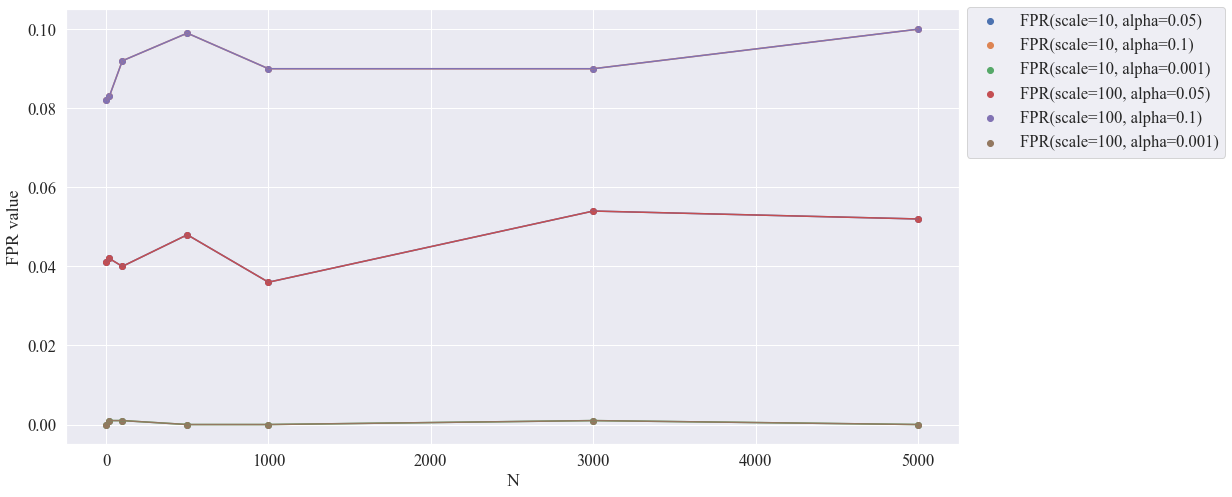

In [12]:
sns.set_theme(font="Times New Roman", font_scale=1.5)

plt.figure(figsize=(16,8))
# plt.yscale('log')

for scale in scale_poss:
    for alpha in alpha_poss:
        tmp = arr_points1[(arr_points1[:, 1] == scale) & (arr_points1[:, 2] == alpha)]
        # pprint(tmp.tolist())
        x, y = tmp[:, 0], tmp[:, 3]
        # print(x, y)
        plt.scatter(x, y, label=f"FPR({scale=}, {alpha=})")
        plt.plot(x, y)

plt.xlabel("N")
plt.ylabel("FPR value")
plt.legend(bbox_to_anchor=(1.0, 1.025), loc="upper left")
plt.show()

Линии с одинаковой альфой, но разной дисперсией совпадают, а значит дисперсия на критерий не влияет. Чем больше $\alpha$ тем больше ошибок первого рода, но как мы знаем, тем больше и мощность.

# Эксперимент II

In [13]:
const = namedtuple("consts", [
    "MU_TRUE",
    "MU_H0",
    "N",
    "SCALE",
    "ALPHA",
    "RUN_REPEATS"
])(
    MU_TRUE=2,
    MU_H0=0,
    N=500,
    SCALE=10,
    ALPHA=0.05,
    RUN_REPEATS=1000
)

In [14]:
falses1, trues1 = [0] * 2

dist = stats.norm.freeze(loc=const.MU_TRUE, scale=const.SCALE)
seed(101)

for _ in tqdm_notebook(range(const.RUN_REPEATS)):
    rvs = dist.rvs(size=const.N)
    test_res1 = my_t_test_1(Xn=rvs, mu_0=const.MU_H0, alpha=const.ALPHA)

    falses1 += 1 - test_res1 # if test_res == 0 its incorrect, inc
    trues1 += test_res1 # if test_res == 1 its correct, inc

FNR = falses1 / (trues1 + falses1)
print(f"{falses1=}")
print(f"{trues1=}")
print(f"{FNR=}")


falses1=6
trues1=994
FNR=0.006


# Эксперимент II с разными параметрами

In [15]:
n_poss = [2, 20, 100, 500, 1000, 3000, 5000]
alpha_poss = [0.05, 0.1, 0.001]
mu_true_poss = np.linspace(0, 3, 4)
# scale как мы помним не влияет на критерий

In [16]:
points = []

In [17]:
for n in n_poss:
    for alpha in alpha_poss:
        for mu_true in mu_true_poss:
            falses1, trues1 = [0] * 2

            dist = stats.norm.freeze(loc=mu_true, scale=const.SCALE)
            seed(101)

            for _ in tqdm_notebook(range(const.RUN_REPEATS)):
                rvs = dist.rvs(size=n)
                test_res1 = my_t_test_1(Xn=rvs, mu_0=const.MU_H0, alpha=alpha)

                falses1 += 1 - test_res1 # if test_res == 0 its incorrect, inc
                trues1 += test_res1 # if test_res == 1 its correct, inc

            FNR = falses1 / (trues1 + falses1)

            points.append((n, alpha, mu_true, FNR))

In [18]:
arr_points = np.array(points)

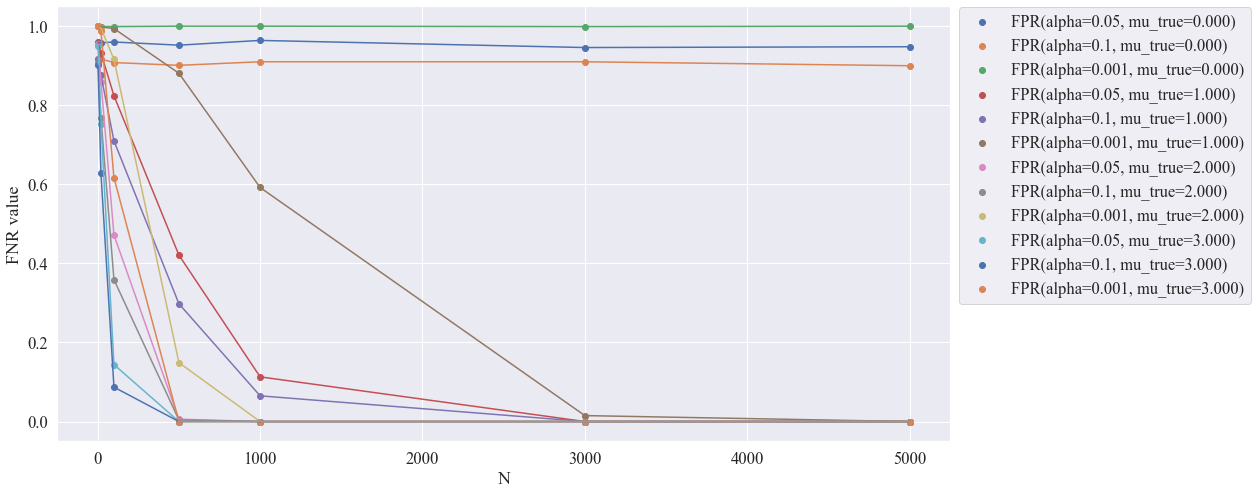

In [19]:
sns.set_theme(font="Times New Roman", font_scale=1.5)

plt.figure(figsize=(16,8))


for mu_true in mu_true_poss:
    for alpha in alpha_poss:
        tmp = arr_points[(arr_points[:, 1] == alpha) & (arr_points[:, 2] == mu_true)]

        x, y = tmp[:, 0], tmp[:, 3]

        plt.scatter(x, y, label=f"FPR({alpha=}, {mu_true=:.3f})")
        plt.plot(x, y)

plt.xlabel("N")
plt.ylabel("FNR value")
plt.legend(bbox_to_anchor=(1.0, 1.017), loc="upper left")
plt.show()

Как мы видим существуют $\mu$, для которых даже с увелечением N, FNR не сходится к нулю. Это $\mu$ для которых гипотеза $H_{0}$ верна. При остальных $\mu$ FNR сходится к нулю. Асимптотика этой сходимости зависит от того насколько $\mu$ близко $\mu_{0}$. Также можно заметить, что зависимость FNR от N обратно пропорциональна.